In [1]:
!pip install transformers==4.40.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.0 which is incompatible.


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

from transformers import logging
logging.set_verbosity_error()

import os
import time
import torch
import pandas as pd
from tqdm.auto import tqdm

# 1) Import CheXagent
from transformers import AutoTokenizer, AutoModelForCausalLM
class CheXagent:
    def __init__(self, model_name="StanfordAIMI/CheXagent-2-3b"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.dtype  = torch.bfloat16 if "cuda" in self.device else torch.float32
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        self.model     = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            trust_remote_code=True
        ).to(self.dtype).to(self.device).eval()

    def generate(self, paths, prompt):
        # build multimodal query
        q = self.tokenizer.from_list_format(
            [*({"image": p} for p in paths), {"text": prompt}]
        )
        conv = [
            {"from": "system", "value": "You are a helpful assistant."},
            {"from": "human",  "value": q},
        ]
    
        # 1) apply template → maybe a Tensor, maybe a dict
        out = self.tokenizer.apply_chat_template(
            conv, add_generation_prompt=True, return_tensors="pt"
        )
        if isinstance(out, torch.Tensor):
            input_ids = out.to(self.device)
        else:
            input_ids = out["input_ids"].to(self.device)
    
        # 2) generate
        output_ids = self.model.generate(
            input_ids,
            do_sample=False,
            num_beams=1,
            max_new_tokens=512,
            pad_token_id=self.tokenizer.eos_token_id,
            eos_token_id=self.tokenizer.eos_token_id,
        )[0]
    
        # 3) decode only the newly generated tokens
        gen = output_ids[input_ids.size(1) : ]
        response = self.tokenizer.decode(gen, skip_special_tokens=True)
        return response


    def disease_identification(self, paths, disease_list):
        prompt = "Given the CXR, identify any diseases. Options:\n" + ", ".join(disease_list)
        return self.generate(paths, prompt)


# 2) Setup paths & read GT
IMAGE_DIR = "/kaggle/input/chest-x-ray-images/test_data"
GT_CSV    = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"

gt_df = pd.read_csv(GT_CSV)
gt_df["ImageName"] = gt_df["ImageName"].apply(os.path.basename)

# 3) Define diseases & instantiate CheXagent
DISEASES = [c for c in gt_df.columns if c != "ImageName"]
agent = CheXagent()

# 4) Run inference
records = []
times = []

for img_name in tqdm(gt_df["ImageName"], desc="Inferring"):
    img_path = os.path.join(IMAGE_DIR, img_name)
    
    t0 = time.time()
    reply = agent.disease_identification([img_path], DISEASES)
    t1 = time.time()
    times.append(t1 - t0)
    
    # normalize reply and split on commas / 'and'
    tokens = [t.strip().lower() for t in reply.replace("and",",").split(",")]
    
    # build row: 1 if disease appears in tokens else 0
    row = {"ImageName": img_name}
    for d in DISEASES:
        row[d] = 1 if d.lower() in tokens else 0
    
    records.append(row)

# 5) Save predictions + timing
pred_df = pd.DataFrame(records)
pred_df["InferenceTime_s"] = times
pred_df.to_csv("chexagent_disease_id_preds.csv", index=False)

# 6) Compare to GT
merged = gt_df.merge(pred_df, on="ImageName", suffixes=("_gt","_pred"))

# compute per-condition accuracy
from sklearn.metrics import accuracy_score

accs = {}
for d in DISEASES:
    y_true = merged[f"{d}_gt"]
    y_pred = merged[f"{d}_pred"]
    accs[d] = accuracy_score(y_true, y_pred)

# overall accuracy (flatten all labels)
all_true = merged[[f"{d}_gt" for d in DISEASES]].values.flatten()
all_pred = merged[[f"{d}_pred" for d in DISEASES]].values.flatten()
overall_acc = accuracy_score(all_true, all_pred)

# 7) Print results
print(f"Overall accuracy: {overall_acc:.3f}")
print("Per-condition accuracy:")
for d, a in accs.items():
    print(f"  {d:20s}: {a:.3f}")
print(f"Average inference time per image: {sum(times)/len(times):.2f}s")


tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

tokenization_chexagent.py:   0%|          | 0.00/26.3k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.85k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

configuration_chexagent.py:   0%|          | 0.00/9.35k [00:00<?, ?B/s]

modeling_chexagent.py:   0%|          | 0.00/53.7k [00:00<?, ?B/s]

modeling_visual.py:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

2025-05-16 12:32:12.739157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747398732.932513      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747398732.986611      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json:   0%|          | 0.00/75.8k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.60G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Inferring:   0%|          | 0/7793 [00:00<?, ?it/s]

Overall accuracy: 0.609
Per-condition accuracy:
  Atelectasis         : 0.569
  Consolidation       : 0.611
  Infiltration        : 0.306
  Pneumothorax        : 0.609
  Edema               : 0.518
  Emphysema           : 0.804
  Fibrosis            : 0.775
  Effusion            : 0.455
  Pneumonia           : 0.537
  Pleural_Thickening  : 0.664
  Cardiomegaly        : 0.410
  Nodule              : 0.670
  Mass                : 0.677
  Hernia              : 0.689
  Lung Lesion         : 0.818
  Fracture            : 0.725
  Lung Opacity        : 0.599
  Enlarged Cardiomediastinum: 0.526
Average inference time per image: 2.79s


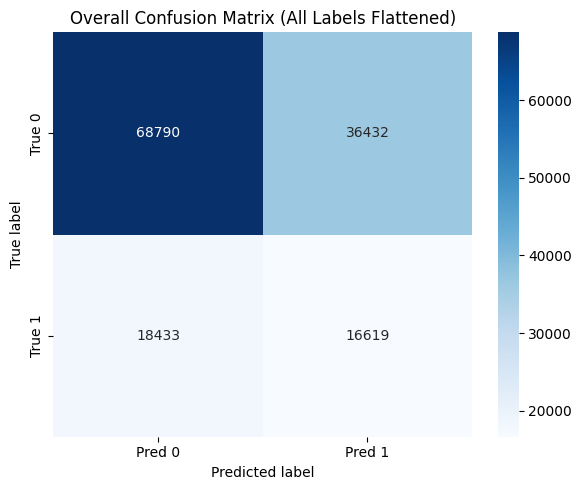

In [3]:
# ───────────────────────────────────────────────────
# 8) Compute & plot overall confusion matrix
# ───────────────────────────────────────────────────
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten all ground truth and predicted labels
y_true = merged[[f"{d}_gt" for d in DISEASES]].values.flatten()
y_pred = merged[[f"{d}_pred" for d in DISEASES]].values.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Save as CSV
cm_df = pd.DataFrame(
    cm,
    index=["True 0","True 1"],
    columns=["Pred 0","Pred 1"]
)
cm_df.to_csv("confusion_matrix.csv", index=True)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Overall Confusion Matrix (All Labels Flattened)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()
